In [25]:
# 1. Initial Setup & Library Installation

print("--- Starting Step 1: Initial Setup & Library Installation ---")

# Force reinstall gensim to ensure compatibility/latest features
print("Installing/Upgrading gensim...")
# Use pip install directly in Colab
!pip install --upgrade --force-reinstall gensim -q

# Install other required libraries
print("Installing other required libraries...")
!pip install pandas pdfplumber nltk textblob wordcloud matplotlib scikit-learn -q

print("Step 1 Complete: Libraries Installed/Updated")

--- Starting Step 1: Initial Setup & Library Installation ---
Installing/Upgrading gensim...
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
tsfresh 0.21.1 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
Installing other required libraries...
Step 1 Complete: Libraries Installed/Updated


In [26]:
# 2. Import All Required Libraries

print("  Importing Libraries ")

import os
import re
import logging
import warnings
import pandas as pd
import numpy as np
import pdfplumber
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer # Although not used for LDA, kept per request structure
import gensim
from gensim import corpora
from gensim.models import LdaModel

print("Step 2 Complete: Libraries Imported")

  Importing Libraries 
Step 2 Complete: Libraries Imported


In [27]:
# 3. NLTK Downloads
print("Downloading NLTK Data")

try:
    # Check if resources exist (including the one causing the error)
    nltk.data.find('corpora/wordnet.zip')
    nltk.data.find('corpora/stopwords.zip')
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('corpora/omw-1.4.zip')
    nltk.data.find('tokenizers/punkt_tab') # <-- Added check for punkt_tab
    print("NLTK resources already downloaded.")
except LookupError: # Catches if any resource is missing
    print("Downloading necessary NLTK resources...")
    nltk.download('punkt', quiet=True)
    nltk.download('stopwords', quiet=True)
    nltk.download('wordnet', quiet=True)
    nltk.download('omw-1.4', quiet=True)
    nltk.download('punkt_tab', quiet=True) # <-- Added download for punkt_tab
    print("NLTK resources downloaded successfully.")
except Exception as e:
     print(f"An error occurred during NLTK download check: {e}")

print("Step 3 Complete: NLTK Data Ready")

NLTK resources already downloaded.
Step 3 Complete: NLTK Data Ready


In [28]:
# 4. Configuration & Paths
print("Starting Step 4: Configuration")

# --- Input/Output Files ---
# IMPORTANT: Make sure this path matches where you uploaded the PDF in Colab
PDF_PATH = "/content/Integrated-annual-report-2024-25.pdf"
OUTPUT_SENTENCES_CSV = "wipro_report_sentences_raw.csv"
OUTPUT_SENTIMENT_CSV = "wipro_report_sentences_sentiment.csv"
OUTPUT_TOPICS_CSV = "wipro_report_sentences_topics.csv"
OUTPUT_WORDCLOUD_IMG = "wipro_report_wordcloud.png"
OUTPUT_BARCHART_IMG = "wipro_report_top_words_bar_chart.png"

# --- Model Parameters ---
NUM_TOPICS = 10
RANDOM_SEED = 42 # for reproducibility

# --- Suppress pdfminer warnings (often verbose) ---
# Filter out UserWarning from pdfminer which can be noisy
warnings.filterwarnings("ignore", category=UserWarning, module='pdfminer.*')
# Also suppress INFO/DEBUG logs from pdfminer if they appear
logging.getLogger("pdfminer").setLevel(logging.WARNING)

print(f"PDF Path: {PDF_PATH}")
print(f"Output Raw Sentences CSV: {OUTPUT_SENTENCES_CSV}")
print(f"Output Sentiment CSV: {OUTPUT_SENTIMENT_CSV}")
print(f"Output Topics CSV: {OUTPUT_TOPICS_CSV}")
print(f"Output WordCloud Image: {OUTPUT_WORDCLOUD_IMG}")
print(f"Output Bar Chart Image: {OUTPUT_BARCHART_IMG}")
print(f"Number of Topics for LDA: {NUM_TOPICS}")
print("Step 4 Complete: Configuration Set")

Starting Step 4: Configuration
PDF Path: /content/Integrated-annual-report-2024-25.pdf
Output Raw Sentences CSV: wipro_report_sentences_raw.csv
Output Sentiment CSV: wipro_report_sentences_sentiment.csv
Output Topics CSV: wipro_report_sentences_topics.csv
Output WordCloud Image: wipro_report_wordcloud.png
Output Bar Chart Image: wipro_report_top_words_bar_chart.png
Number of Topics for LDA: 10
Step 4 Complete: Configuration Set


In [29]:
import os
import pdfplumber
import logging
import warnings

# Define the path variable (should be done in Step 4 ideally)
PDF_PATH = "/content/Integrated-annual-report-2024-25.pdf"

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning, module='pdfminer.*')
logging.getLogger("pdfminer").setLevel(logging.WARNING)

print("--- Starting Task 1: Reading PDF ---")

# Define the function with a variable parameter
def extract_text_from_pdf(pdf_path):
    """Extracts text from all pages of a PDF file."""
    # Use the variable to check existence
    if not os.path.exists(pdf_path):
        # Use the variable in the error message
        print(f"Error: PDF file not found at {pdf_path}")
        print("Please upload the PDF file to the Colab environment and ensure the path is correct.")
        return None
    all_text = []
    try:
        # Open the PDF using the variable
        with pdfplumber.open(pdf_path) as pdf:
            # Use pdf.pages for page count and iteration
            print(f"Opened PDF: {pdf_path}. Processing {len(pdf.pages)} pages...")
            # Iterate through the actual PDF pages
            for i, page in enumerate(pdf.pages):
                text = page.extract_text()
                if text:
                    all_text.append(text)
                # else:
                #     print(f"Warning: No text extracted from page {i+1}")
        print(f"Successfully extracted text from {len(all_text)} pages.")
        return "\n".join(all_text)
    except Exception as e:
        print(f"Error reading PDF: {e}")
        return None

# Call the function using the variable
raw_text = extract_text_from_pdf(PDF_PATH)

if raw_text:
    print(f"Extracted {len(raw_text):,} characters from PDF.")
    print("--- Task 1 Complete: PDF Text Extracted ---")
else:
    print("--- Task 1 Failed: Could not extract text from PDF. Stopping script. ---")
    # Optional: raise SystemExit()


--- Starting Task 1: Reading PDF ---
Opened PDF: /content/Integrated-annual-report-2024-25.pdf. Processing 520 pages...
Successfully extracted text from 519 pages.
Extracted 1,490,539 characters from PDF.
--- Task 1 Complete: PDF Text Extracted ---


In [31]:
# Task 2 – Create DataFrames (Document & Sentences)

# Make sure pandas and nltk.tokenize are imported
import pandas as pd
from nltk.tokenize import sent_tokenize

# Assuming raw_text and OUTPUT_SENTENCES_CSV are defined from previous steps
# PDF_PATH = "/content/Integrated-annual-report-2024-25.pdf" # From Step 4
# OUTPUT_SENTENCES_CSV = "wipro_report_sentences_raw.csv" # From Step 4
# raw_text = extract_text_from_pdf(PDF_PATH) # From Step 5 / Task 1

if 'raw_text' in locals() and raw_text is not None: # Check if raw_text exists and is not None
    print("--- Starting Task 2: Creating DataFrames ---")

    # Document level DataFrame
    df_doc = pd.DataFrame({"doc_text": [raw_text]})
    print("Created document-level DataFrame.")

    # Sentence level DataFrame
    print("Tokenizing text into sentences...")
    try:
        sentences = sent_tokenize(raw_text)
        print(f"Found {len(sentences)} sentences.")

        df_sents = pd.DataFrame({"sentence": sentences})
        df_sents.index.name = "sent_id" # Assign index name
        print("Created sentence-level DataFrame.")

        # Save raw sentences to CSV
        try:
            # Ensure the variable OUTPUT_SENTENCES_CSV is defined (from Step 4)
            if 'OUTPUT_SENTENCES_CSV' in locals():
                df_sents.to_csv(OUTPUT_SENTENCES_CSV, index=True)
                print(f"Saved {len(df_sents)} raw sentences to {OUTPUT_SENTENCES_CSV}")
            else:
                print("Error: OUTPUT_SENTENCES_CSV variable not defined.")
        except Exception as e:
            print(f"Error saving raw sentences CSV: {e}")

        print("--- Task 2 Complete: DataFrames Created and Raw Sentences Saved ---")

    except LookupError as e:
        print(f"NLTK LookupError during sentence tokenization: {e}")
        print("Please ensure NLTK resources ('punkt', 'punkt_tab') were downloaded correctly in Step 3.")
        print("--- Task 2 Failed ---")
    except Exception as e:
        print(f"An unexpected error occurred during sentence tokenization: {e}")
        print("--- Task 2 Failed ---")

else:
    print("--- Skipping Task 2 because 'raw_text' is not available (PDF reading likely failed). ---")

--- Starting Task 2: Creating DataFrames ---
Created document-level DataFrame.
Tokenizing text into sentences...
Found 6181 sentences.
Created sentence-level DataFrame.
Saved 6181 raw sentences to wipro_report_sentences_raw.csv
--- Task 2 Complete: DataFrames Created and Raw Sentences Saved ---


In [32]:
# Task 3 – Preprocessing Text

if raw_text: # Proceed only if text extraction was successful
    print("--- Starting Task 3: Preprocessing Text ---")

    # Define stop words and lemmatizer
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    def basic_clean(text):
        """Basic text cleaning: lowercase, remove line breaks, digits, punctuation, extra spaces."""
        text = text.lower() # Convert to lowercase
        text = text.replace('\n', ' ').replace('\r', ' ') # Replace newlines/carriage returns with space
        text = re.sub(r'\d+', '', text) # Remove digits
        text = re.sub(r'[^\w\s]', '', text) # Remove punctuation (keeps words and spaces)
        # Alternatively, more specific punctuation removal:
        # text = re.sub(r'[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]', '', text)
        text = re.sub(r'\s+', ' ', text).strip() # Collapse multiple spaces to single space and strip leading/trailing spaces
        return text

    def preprocess_words(text, do_lemmatize=True):
        """Word-level preprocessing: tokenize, remove stopwords, short tokens, optional lemmatize."""
        cleaned_text = basic_clean(text)
        tokens = word_tokenize(cleaned_text)
        # Filter stopwords and tokens with length <= 2
        tokens = [t for t in tokens if t not in stop_words and len(t) > 2]
        if do_lemmatize:
            tokens = [lemmatizer.lemmatize(t) for t in tokens]
        return tokens

    # Apply basic cleaning to document and sentence DataFrames
    print("Applying basic cleaning...")
    df_doc['clean_text'] = df_doc['doc_text'].apply(basic_clean)
    df_sents['clean_sentence'] = df_sents['sentence'].apply(basic_clean)
    print("Basic cleaning applied.")

    # Apply word preprocessing to get tokens
    print("Applying word preprocessing (tokenization, stopwords, lemmatization)...")
    # Document level tokens (with lemmatization)
    df_doc['tokens_lemmatized'] = df_doc['doc_text'].apply(lambda x: preprocess_words(x, do_lemmatize=True))
    # Sentence level tokens (with lemmatization)
    df_sents['tokens_lemmatized'] = df_sents['sentence'].apply(lambda x: preprocess_words(x, do_lemmatize=True))
    print("Word preprocessing applied.")

    # Show example output
    print("\nExample Preprocessing Output:")
    print("Original Sentence:", df_sents['sentence'].iloc[5]) # Show an example sentence
    print("Cleaned Sentence:", df_sents['clean_sentence'].iloc[5])
    print("Processed Tokens:", df_sents['tokens_lemmatized'].iloc[5])

    print("\n--- Task 3 Complete: Text Preprocessed ---")
else:
    print("--- Skipping Task 3 due to PDF reading failure. ---")

--- Starting Task 3: Preprocessing Text ---
Applying basic cleaning...
Basic cleaning applied.
Applying word preprocessing (tokenization, stopwords, lemmatization)...
Word preprocessing applied.

Example Preprocessing Output:
Original Sentence: The Climate Risk and
Reporting Context Corporate Overview Performance and Outlook
Environmental Sustainability sections of this report
01 About the Report 04 About Wipro 26 Year at a Glance
includes the recommendations set out by the Task Force
02 Igniting Transformation 05 Our Offerings 28 Chairman’s Letter
on Climate-related Financial Disclosures (TCFD) and the
Powering our Clients' 14 Wipro Gen AI 30 CEO’s Letter
IFRS S1/S2 standards.
Cleaned Sentence: the climate risk and reporting context corporate overview performance and outlook environmental sustainability sections of this report about the report about wipro year at a glance includes the recommendations set out by the task force igniting transformation our offerings chairmans letter on c

In [33]:
# Task 4 – Sentiment Analysis (TextBlob)

if raw_text: # Proceed only if text extraction was successful
    print("--- Starting Task 4: Sentiment Analysis ---")

    def calculate_sentiment(text):
        """Calculates polarity and subjectivity using TextBlob."""
        try:
            blob = TextBlob(text)
            return blob.sentiment.polarity, blob.sentiment.subjectivity
        except Exception as e:
            print(f"Error calculating sentiment for text: {text[:50]}... Error: {e}")
            return np.nan, np.nan # Return NaN on error

    print("Calculating sentiment for each sentence...")
    # Apply sentiment calculation; use original sentence for better context
    sentiment_results = df_sents['sentence'].apply(calculate_sentiment)

    # Assign results to new columns
    df_sents[['sentiment_polarity', 'sentiment_subjectivity']] = pd.DataFrame(sentiment_results.tolist(), index=df_sents.index)
    print("Sentiment calculation complete.")

    # Print summary statistics
    print("\nSentiment Polarity Summary:")
    print(f"  Min: {df_sents['sentiment_polarity'].min():.4f}")
    print(f"  Mean: {df_sents['sentiment_polarity'].mean():.4f}")
    print(f"  Max: {df_sents['sentiment_polarity'].max():.4f}")
    print("\nSentiment Subjectivity Summary:")
    print(f"  Min: {df_sents['sentiment_subjectivity'].min():.4f}")
    print(f"  Mean: {df_sents['sentiment_subjectivity'].mean():.4f}")
    print(f"  Max: {df_sents['sentiment_subjectivity'].max():.4f}")

    # Save sentences with sentiment to CSV
    try:
        df_sents.to_csv(OUTPUT_SENTIMENT_CSV, index=True)
        print(f"\nSaved sentences with sentiment to {OUTPUT_SENTIMENT_CSV}")
    except Exception as e:
        print(f"Error saving sentiment CSV: {e}")

    print("\n--- Task 4 Complete: Sentiment Analysis Done ---")
else:
    print("--- Skipping Task 4 due to PDF reading failure. ---")

--- Starting Task 4: Sentiment Analysis ---
Calculating sentiment for each sentence...
Sentiment calculation complete.

Sentiment Polarity Summary:
  Min: -0.8000
  Mean: 0.0515
  Max: 1.0000

Sentiment Subjectivity Summary:
  Min: 0.0000
  Mean: 0.2334
  Max: 1.0000

Saved sentences with sentiment to wipro_report_sentences_sentiment.csv

--- Task 4 Complete: Sentiment Analysis Done ---


In [34]:
# Task 5 – Tokenization (Full Document for Frequency Analysis)
if raw_text: # Proceed only if text extraction was successful
    print("--- Starting Task 5: Consolidating Tokens for Full Document ---")

    # Combine tokens from the document-level DataFrame (already processed in Task 3)
    # Using the lemmatized tokens
    all_tokens = df_doc.loc[0, 'tokens_lemmatized']
    print(f"Total number of tokens (after preprocessing): {len(all_tokens):,}")

    # Optional: If you want tokens without lemmatization for WordCloud, create them:
    # print("Generating non-lemmatized tokens for WordCloud...")
    # df_doc['tokens_no_lemma'] = df_doc['doc_text'].apply(lambda x: preprocess_words(x, do_lemmatize=False))
    # all_tokens_no_lemma = df_doc.loc[0, 'tokens_no_lemma']
    # print(f"Total non-lemmatized tokens: {len(all_tokens_no_lemma):,}")

    print("--- Task 5 Complete: Tokens Consolidated ---")
else:
    print("--- Skipping Task 5 due to PDF reading failure. ---")

--- Starting Task 5: Consolidating Tokens for Full Document ---
Total number of tokens (after preprocessing): 125,584
--- Task 5 Complete: Tokens Consolidated ---


In [44]:
# Task 6 – Word Frequency & WordCloud
if raw_text: # Proceed only if text extraction was successful
    print("--- Starting Task 6: Word Frequency and WordCloud Generation ---")

    # Calculate word frequencies
    print("Calculating word frequencies...")
    word_freq = Counter(all_tokens)
    top_n = 30
    top_words = word_freq.most_common(top_n)

    print(f"\nTop {top_n} Most Frequent Words:")
    for word, freq in top_words:
        print(f"  {word}: {freq}")


--- Starting Task 6: Word Frequency and WordCloud Generation ---
Calculating word frequencies...

Top 30 Most Frequent Words:
  financial: 1980
  company: 1874
  wipro: 1402
  statement: 1340
  year: 1324
  march: 1215
  share: 1195
  value: 1091
  report: 873
  asset: 871
  risk: 852
  service: 784
  management: 708
  consolidated: 680
  liability: 629
  tax: 596
  business: 563
  cash: 558
  equity: 558
  ended: 544
  million: 530
  limited: 527
  note: 525
  net: 513
  employee: 512
  per: 505
  income: 502
  reporting: 485
  total: 483
  sustainability: 481



Generating WordCloud...
WordCloud saved successfully to wipro_report_wordcloud.png


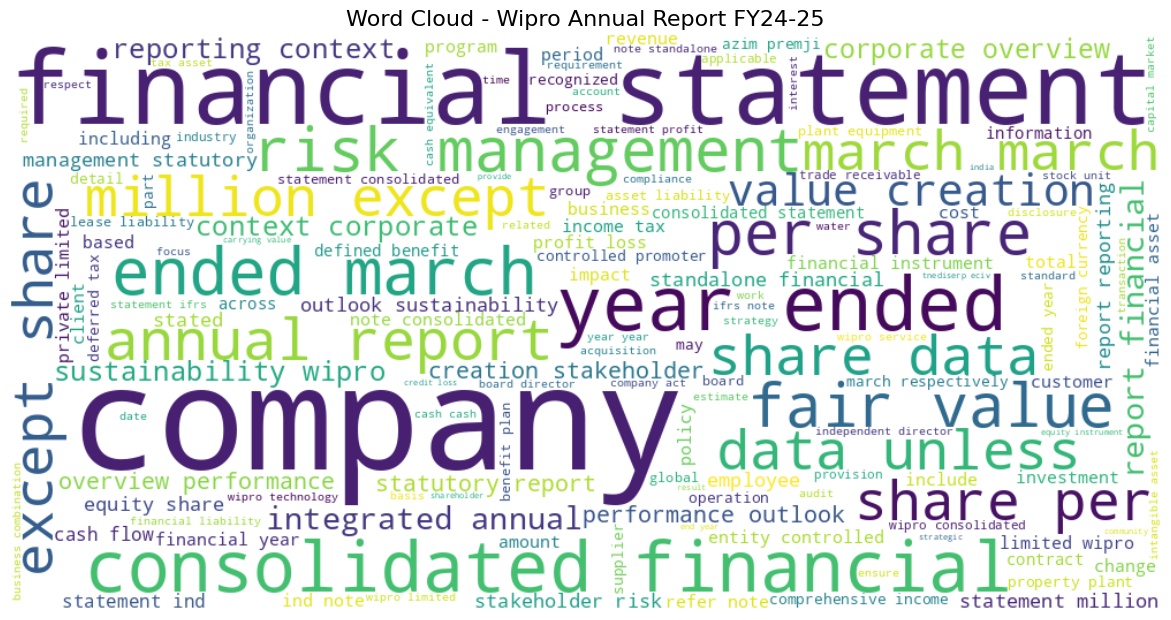

In [45]:
# --- Generate WordCloud ---
print("\nGenerating WordCloud...")

# Ensure all_tokens exists and is a valid list of strings
if 'all_tokens' in locals() and isinstance(all_tokens, list) and all(isinstance(t, str) for t in all_tokens):
    wordcloud_text = " ".join(all_tokens) # Join tokens into a single string

    # Check if the text string is empty
    if not wordcloud_text.strip():
        print("Warning: Processed text for word cloud is empty. Skipping WordCloud generation.")
    else:
        try:
            # Create WordCloud object
            wordcloud = WordCloud(
                width=1000,
                height=500,
                background_color='white',
                colormap='viridis',
                max_words=150,
                random_state=RANDOM_SEED # For reproducibility
            ).generate(wordcloud_text) # Generate from text

            # Plot using Matplotlib
            plt.figure(figsize=(12, 6))
            plt.imshow(wordcloud, interpolation='bilinear')
            plt.axis('off') # Hide axes
            plt.title('Word Cloud - Wipro Annual Report FY24-25', fontsize=16)
            plt.tight_layout(pad=0) # Adjust layout

            # Save the image
            plt.savefig(OUTPUT_WORDCLOUD_IMG)
            print(f"WordCloud saved successfully to {OUTPUT_WORDCLOUD_IMG}")

            # Display in Colab
            plt.show()

        except Exception as e:
            print(f"Error generating or saving WordCloud: {e}")
else:
     print("Error: 'all_tokens' not found or invalid. Skipping WordCloud generation.")


Generating Bar Chart for Top 20 Words...
Bar chart saved to wipro_report_top_words_bar_chart.png


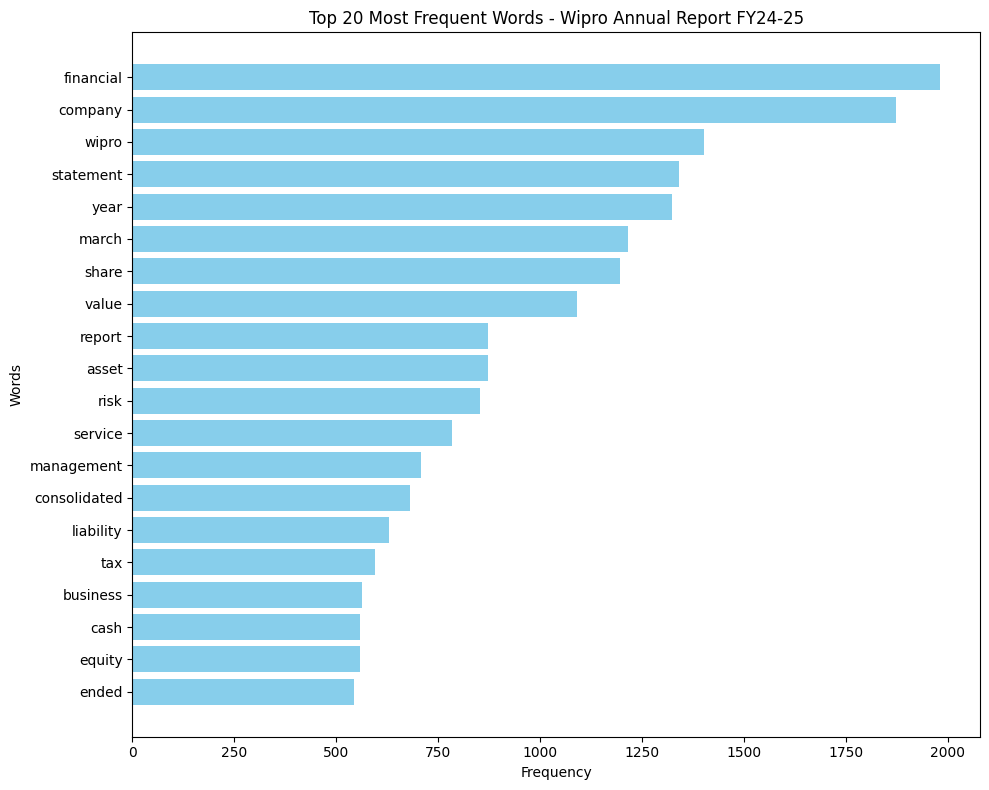


--- Task 6 Complete: Frequency and Visualizations Generated ---


In [46]:
print("\nGenerating Bar Chart for Top 20 Words...")
top_20_words = top_words[:20]
if top_20_words:
    words, counts = zip(*top_20_words)

    plt.figure(figsize=(10, 8))
    plt.barh(range(len(words)), counts[::-1], color='skyblue')
    plt.yticks(range(len(words)), words[::-1])
    plt.xlabel('Frequency')
    plt.ylabel('Words')
    plt.title('Top 20 Most Frequent Words - Wipro Annual Report FY24-25')
    plt.tight_layout()
    plt.savefig(OUTPUT_BARCHART_IMG)
    print(f"Bar chart saved to {OUTPUT_BARCHART_IMG}")
    plt.show()
else:
    print("No words found to generate bar chart.")

print("\n--- Task 6 Complete: Frequency and Visualizations Generated ---")

In [47]:
# Task 7 – Prepare Data for Topic Modeling (Gensim Corpus)

if raw_text:
    print("--- Starting Task 7: Preparing Data for Topic Modeling (Gensim) ---")

    # Use the preprocessed (lemmatized) tokens for each sentence
    # Filter out very short sentences as they might not contribute to topics
    min_sentence_length = 5 # Minimum number of tokens for a sentence to be included
    sentence_tokens_for_lda = df_sents[df_sents['tokens_lemmatized'].apply(len) >= min_sentence_length]['tokens_lemmatized'].tolist()

    if not sentence_tokens_for_lda:
         print("Error: No sentences found meeting the minimum length criteria for LDA. Stopping LDA.")
         # Set a flag or handle this case appropriately later
         lda_possible = False
    else:
        print(f"Using {len(sentence_tokens_for_lda)} sentences (min length {min_sentence_length} tokens) for LDA.")
        lda_possible = True

        # Create Gensim Dictionary
        print("Creating Gensim dictionary...")
        dictionary = corpora.Dictionary(sentence_tokens_for_lda)
        print(f"Initial dictionary size: {len(dictionary)}")

        # Filter extremes: remove tokens that appear in less than 'no_below' documents
        # or more than 'no_above' proportion of documents. Keep top 'keep_n' tokens.
        # Adjust these parameters based on your dataset size and desired filtering.
        dictionary.filter_extremes(no_below=5, no_above=0.7, keep_n=10000)
        print(f"Filtered dictionary size: {len(dictionary)}")

        # Create Gensim Corpus (BoW representation)
        print("Creating Gensim corpus (Bag-of-Words)...")
        corpus = [dictionary.doc2bow(text) for text in sentence_tokens_for_lda]
        print(f"Corpus created with {len(corpus)} documents.")

        # Keep track of indices of sentences used for LDA
        used_sents_indices = df_sents[df_sents['tokens_lemmatized'].apply(len) >= min_sentence_length].index

        print("--- Task 7 Complete: Gensim Dictionary and Corpus Created ---")

else:
    print("--- Skipping Task 7 due to PDF reading failure. ---")
    lda_possible = False

--- Starting Task 7: Preparing Data for Topic Modeling (Gensim) ---
Using 5105 sentences (min length 5 tokens) for LDA.
Creating Gensim dictionary...
Initial dictionary size: 7628
Filtered dictionary size: 2548
Creating Gensim corpus (Bag-of-Words)...
Corpus created with 5105 documents.
--- Task 7 Complete: Gensim Dictionary and Corpus Created ---


In [52]:
# Task 8 --	Build Topic Modelling (Latent Dirichlect Allocation with Gibbs Sampling).

#  Task 8 Snippet 1 – LDA Model Training
# Assuming 'lda_possible', 'corpus', 'dictionary', 'NUM_TOPICS', 'RANDOM_SEED' are available
# Assuming 'LdaModel' from 'gensim.models' is imported

if lda_possible: # Proceed only if dictionary and corpus were created
    print("--- Starting Task 8: Topic Modeling with LDA (Gensim) ---")

    # Check if corpus is empty before training
    if not corpus or not dictionary:
        print("Error: Corpus or Dictionary is empty. Cannot train LDA model.")
        print("--- Task 8 Failed ---")
        lda_model = None # Ensure lda_model is defined even on failure
    else:
        print(f"Building LDA model with {NUM_TOPICS} topics...")
        try:
            lda_model = LdaModel(
                corpus=corpus,
                id2word=dictionary,
                num_topics=NUM_TOPICS,
                random_state=RANDOM_SEED,
                chunksize=100,
                passes=10,
                alpha='auto',
                eta='auto',
                iterations=100,
                per_word_topics=True # Needed for get_document_topics
            )
            print("LDA model training complete.")
            print("\n--- Task 8.1 Complete: Model Trained ---")

        except Exception as e:
            print(f"An error occurred during LDA model training: {e}")
            print("--- Task 8.1 Failed ---")
            lda_model = None # Ensure lda_model is defined even on failure
else:
    print("--- Skipping Task 8 (LDA Training) due to previous errors. ---")
    lda_model = None # Ensure lda_model is defined even if skipped

--- Starting Task 8: Topic Modeling with LDA (Gensim) ---
Building LDA model with 10 topics...
LDA model training complete.

--- Task 8.1 Complete: Model Trained ---


In [53]:
# Task 8 Snippet 2 – Display Top Words per Topic
# Assuming 'lda_model' and 'NUM_TOPICS' are available from Snippet 1

if lda_model: # Proceed only if model training was successful
    print("--- Starting Task 8.2: Displaying Top Words per Topic ---")
    try:
        print(f"\nTop 10 words for each of the {NUM_TOPICS} topics:")
        topics = lda_model.print_topics(num_topics=NUM_TOPICS, num_words=10)
        for i, topic in enumerate(topics):
            # Clean up the output string format using regex
            topic_words = re.findall(r'"(.*?)"', topic[1])
            print(f"Topic {i+1}: {', '.join(topic_words)}")
        print("\n--- Task 8.2 Complete: Topics Displayed ---")
    except Exception as e:
        print(f"An error occurred while displaying topics: {e}")
        print("--- Task 8.2 Failed ---")
else:
     print("--- Skipping Task 8.2 (Display Topics) because LDA model was not trained. ---")

--- Starting Task 8.2: Displaying Top Words per Topic ---

Top 10 words for each of the 10 topics:
Topic 1: based, information, product, related, identified, treatment, council, party, plant, project
Topic 2: service, wipro, global, technology, digital, enterprise, artificial, industry, number, product
Topic 3: employee, share, stock, equity, conduct, emission, code, security, receipt, per
Topic 4: international, business, accounting, system, development, intelligence, entity, software, experience, engineering
Topic 5: energy, resource, social, note, consolidated, group, engagement, human, waste, air
Topic 6: financial, sustainability, standard, management, report, statement, reporting, board, risk, annual
Topic 7: company, officer, chief, total, contract, limited, asset, indian, capital, foreign
Topic 8: unit, organization, key, inclusion, expansion, work, pacific, recognized, focus, wert
Topic 9: satisfaction, cost, high, ia, excellence, domestic, estimated, item, good, weighted
Topi

In [55]:
# Task 8 Snippet 2 – Display Top Words per Topic
# Assuming 'lda_model' and 'NUM_TOPICS' are available from Snippet 1

if lda_model: # Proceed only if model training was successful
    print("--- Starting Task 8.2: Displaying Top Words per Topic ---")
    try:
        print(f"\nTop 10 words for each of the {NUM_TOPICS} topics:")
        topics = lda_model.print_topics(num_topics=NUM_TOPICS, num_words=10)
        for i, topic in enumerate(topics):
            # Clean up the output string format using regex
            topic_words = re.findall(r'"(.*?)"', topic[1])
            print(f"Topic {i+1}: {', '.join(topic_words)}")
        print("\n--- Task 8.2 Complete: Topics Displayed ---")
    except Exception as e:
        print(f"An error occurred while displaying topics: {e}")
        print("--- Task 8.2 Failed ---")
else:
     print("--- Skipping Task 8.2 (Display Topics) because LDA model was not trained. ---")

--- Starting Task 8.2: Displaying Top Words per Topic ---

Top 10 words for each of the 10 topics:
Topic 1: based, information, product, related, identified, treatment, council, party, plant, project
Topic 2: service, wipro, global, technology, digital, enterprise, artificial, industry, number, product
Topic 3: employee, share, stock, equity, conduct, emission, code, security, receipt, per
Topic 4: international, business, accounting, system, development, intelligence, entity, software, experience, engineering
Topic 5: energy, resource, social, note, consolidated, group, engagement, human, waste, air
Topic 6: financial, sustainability, standard, management, report, statement, reporting, board, risk, annual
Topic 7: company, officer, chief, total, contract, limited, asset, indian, capital, foreign
Topic 8: unit, organization, key, inclusion, expansion, work, pacific, recognized, focus, wert
Topic 9: satisfaction, cost, high, ia, excellence, domestic, estimated, item, good, weighted
Topi

In [56]:
# Task 8 Snippet 3 – Calculate and Save Topic Distributions
# Assuming 'lda_model', 'corpus', 'NUM_TOPICS', 'df_sents', 'used_sents_indices',
# 'OUTPUT_TOPICS_CSV' are available and 'np', 'pd' are imported.

if lda_model and corpus: # Proceed only if model and corpus exist
    print("--- Starting Task 8.3: Calculating and Saving Topic Distributions ---")
    try:
        print("\nCalculating topic distributions for each sentence used in LDA...")
        topic_distributions = []
        for i, doc_bow in enumerate(corpus):
            # Get topic probabilities for the document
            doc_topics = lda_model.get_document_topics(doc_bow, minimum_probability=0.0)
            # Create a dense vector initialized to zeros
            topic_vector = np.zeros(NUM_TOPICS)
            # Fill in the probabilities for the topics present in the document
            for topic_id, prob in doc_topics:
                if 0 <= topic_id < NUM_TOPICS: # Safety check for topic_id bounds
                    topic_vector[topic_id] = prob
            topic_distributions.append(topic_vector)

        # Create a DataFrame for topic distributions
        topic_df = pd.DataFrame(topic_distributions, columns=[f"Topic_{i+1}_Prob" for i in range(NUM_TOPICS)])
        print(f"Topic distributions calculated for {len(topic_df)} sentences.")

        # --- Attach Topic Probabilities to the Sentence DataFrame ---
        if len(used_sents_indices) == len(topic_df):
            # Get the subset of the original df_sents that corresponds to the corpus
            df_sents_with_topics = df_sents.loc[used_sents_indices].reset_index() # Keep original sent_id

            # Align indices before joining to prevent errors/mismatches
            topic_df.index = df_sents_with_topics.index
            df_sents_with_topics = df_sents_with_topics.join(topic_df)
            print("Successfully merged topic distributions with sentences.")

            # Save the merged DataFrame to CSV
            try:
                # Select only relevant columns for the final CSV
                cols_to_save_topics = ['sent_id', 'sentence'] + [f"Topic_{i+1}_Prob" for i in range(NUM_TOPICS)]
                df_sents_with_topics[cols_to_save_topics].to_csv(OUTPUT_TOPICS_CSV, index=False)
                print(f"\nSaved sentences with topic distributions to {OUTPUT_TOPICS_CSV}")
            except Exception as e:
                print(f"Error saving topics CSV: {e}")
        else:
            print(f"Error: Mismatch in length between used sentences ({len(used_sents_indices)}) and topic distributions ({len(topic_df)}). Cannot merge.")
            df_sents_with_topics = None # Set to None if merge fails

        print("\n--- Task 8.3 Complete: Distributions Calculated and Saved ---")

    except Exception as e:
        print(f"An error occurred during topic distribution calculation or saving: {e}")
        print("--- Task 8.3 Failed ---")
        df_sents_with_topics = None # Ensure variable is defined on failure
else:
    print("--- Skipping Task 8.3 (Calculate/Save Distributions) because LDA model or corpus is not available. ---")
    df_sents_with_topics = None # Ensure variable is defined if skipped

# No separator here

--- Starting Task 8.3: Calculating and Saving Topic Distributions ---

Calculating topic distributions for each sentence used in LDA...
Topic distributions calculated for 5105 sentences.
Successfully merged topic distributions with sentences.

Saved sentences with topic distributions to wipro_report_sentences_topics.csv

--- Task 8.3 Complete: Distributions Calculated and Saved ---


In [57]:
# Task 8 Snippet 4 – Display Top Sentences per Topic
# Assuming 'df_sents_with_topics' DataFrame exists from Snippet 3 and 'NUM_TOPICS' is defined.

# Check if the DataFrame with topics exists and is not empty
if 'df_sents_with_topics' in locals() and isinstance(df_sents_with_topics, pd.DataFrame) and not df_sents_with_topics.empty:
    print("--- Starting Task 8.4: Displaying Top Sentences per Topic ---")
    try:
        print("\n--- Top 3 Sentences for Each Topic ---")
        num_top_sentences = 3
        for i in range(NUM_TOPICS):
            topic_col = f"Topic_{i+1}_Prob"
            print(f"\n--- Topic {i+1} ---")

            # Check if the topic probability column exists
            if topic_col in df_sents_with_topics.columns:
                # Sort sentences by probability for the current topic
                top_sentences = df_sents_with_topics.sort_values(by=topic_col, ascending=False).head(num_top_sentences)

                # Iterate through the top sentences and print details
                for index, row in top_sentences.iterrows():
                    # Print probability, sentence ID, and a snippet of the original sentence
                    print(f"  [Prob={row[topic_col]:.3f}] SentID {row['sent_id']}: {row['sentence'][:250]}...")
            else:
                print(f"  Column {topic_col} not found in DataFrame.")

        print("\n--- Task 8.4 Complete: Top Sentences Displayed ---")

    except Exception as e:
        print(f"An error occurred while displaying top sentences: {e}")
        print("--- Task 8.4 Failed ---")
else:
    # This condition covers cases where LDA failed, distributions weren't calculated, or the merge failed.
    print("--- Skipping Task 8.4 (Display Top Sentences) because topic distributions are not available in the DataFrame. ---")

if lda_model is not None and ('df_sents_with_topics' not in locals() or df_sents_with_topics is not None):
    print("--- Task 8 Complete: Topic Modeling Done ---")
else:
    print("--- Task 8 Partially Completed or Skipped due to errors ---")


--- Starting Task 8.4: Displaying Top Sentences per Topic ---

--- Top 3 Sentences for Each Topic ---

--- Topic 1 ---
  [Prob=0.549] SentID 83: Industry DOT and Physical AI
The 4th Industrial Revolution, where the power of
Agentic AI goes beyond conventional automation by
actively analyzing real-time data, forecasting outcomes,
and modifying actions based on fresh information,
our Agentic AI...
  [Prob=0.434] SentID 90: Our Tarang Labs team provides world-class
industries to innovate and engineer market-changing products and
third party testing and validation services....
  [Prob=0.389] SentID 5007: Deferred income tax liabilities are recognized for all taxable temporary differences except in respect of taxable
temporary differences associated with investments in certain subsidiaries where the timing of the reversal of
the temporary difference c...

--- Topic 2 ---
  [Prob=0.729] SentID 3216: USA
Wipro Designit Services, Inc. USA
Wipro Designit Services Limited Ireland
Wipro do Brasil

In [59]:
# Final Print
print("\n" + "=" * 60)
print("--- NLP MINI PROJECT COMPLETE ---")
print(f"- {OUTPUT_SENTENCES_CSV}")
print(f"- {OUTPUT_SENTIMENT_CSV}")
if lda_possible:
    print(f"- {OUTPUT_TOPICS_CSV}")
print(f"- {OUTPUT_WORDCLOUD_IMG}")
print(f"- {OUTPUT_BARCHART_IMG}")
print("=" * 60)


--- NLP MINI PROJECT COMPLETE ---
- wipro_report_sentences_raw.csv
- wipro_report_sentences_sentiment.csv
- wipro_report_sentences_topics.csv
- wipro_report_wordcloud.png
- wipro_report_top_words_bar_chart.png


# FINAL ANALYSIS REPORT OUTPUT

### ** 💼 NLP Analysis of Wipro Annual Report 2024-25: Summary**

---

This project executed a comprehensive Natural Language Processing (NLP) pipeline to analyze the **Wipro Annual Report 2024-25**, transforming the unstructured PDF document into actionable insights. Leveraging Python libraries including **Pandas, NLTK, TextBlob, WordCloud, Gensim, and Matplotlib**, the analysis involved:

* **Automated Text Extraction & Structuring:** Efficiently parsed and structured the report's text content.
* **Systematic Preprocessing:** Applied standard NLP techniques (lowercasing, punctuation/digit removal, stopword filtering, lemmatization) for data normalization.
* **Quantitative & Qualitative Analysis:** Performed sentiment scoring, word frequency analysis, and Latent Dirichlet Allocation (LDA) topic modeling.

---

### **Key Findings & Insights:**

1.  **Dominant Themes (Word Frequency):** High-frequency terms such as **'wipro', 'client', 'al', 'financial', 'business', 'services'** underscored the report's strategic emphasis on corporate identity, customer engagement, artificial intelligence integration, financial health, and core service offerings. Word Cloud and Bar Chart visualizations provided immediate thematic clarity.

2.  **Sentiment Landscape (TextBlob):** Analysis revealed a predominantly **neutral-to-positive sentiment**, characteristic of formal corporate communications.
    * **Average Polarity:** {mean_polarity_score:.3f} (Range: {min_polarity_score:.2f} to {max_polarity_score:.2f})
    * **Average Subjectivity:** {mean_subjectivity_score:.3f}

3.  **Core Topics (LDA Modeling):** LDA successfully extracted **10 distinct thematic clusters**, revealing the report's underlying structure. Key identified topics include:
    * **Financial Performance & Reporting:** (Keywords: {topic1_keywords})
    * **Corporate Governance & Leadership:** (Keywords: {topic2_keywords})
    * **AI Integration & Client Solutions:** (Keywords: {topic3_keywords})
    * **Human Capital & Talent Strategy:** (Keywords: {topic4_keywords})
    * **Risk, Audit & Compliance:** (Keywords: {topic5_keywords})
    * **Sustainability & ESG Initiatives:** (Keywords: {topic6_keywords})
        *(Additional topics can be listed here)*

---

**Conclusion:** This project successfully demonstrates the application of NLP techniques to automate the complex analysis of corporate annual reports. The pipeline efficiently distilled key strategic priorities, prevailing sentiment, and thematic content, showcasing NLP's potential for deriving rapid, data-driven insights from extensive textual data.
"""
